# Technical Assesment
Author: [Sébastien Lozano Forero](https://www.linkedin.com/in/sebastienlozanoforero/)

April, 2022. 

This project is based on an technical assessment used by a Colombian bank to fill the position of Data Scientist. Data was modified shared in a modified version not containing any identification information. Currency within this project is set to Colombian pesos. 

# Loading libraries

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import joblib 

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pandas_profiling import ProfileReport


from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
# from boruta import BorutaPy
import natsort
import session_info

In [286]:
session_info.show(html=False)

-----
autopep8            1.6.0
bayes_opt           NA
ipykernel           6.4.1
joblib              1.0.1
matplotlib          3.4.3
natsort             8.1.0
numpy               1.22.0
pandas              1.3.5
pandas_profiling    3.1.0
seaborn             0.11.2
session_info        1.0.0
sklearn             1.0.2
xgboost             1.4.2
-----
IPython             7.31.1
jupyter_client      6.1.12
jupyter_core        4.9.1
jupyterlab          3.2.9
notebook            6.4.8
-----
Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19043-SP0
-----
Session information updated at 2022-04-15 16:42


# Data Loading

In [181]:
data = pd.read_csv('Base_campana_DC.csv',encoding = "ISO-8859-1", sep =';',parse_dates=['fecha_ult_desembolso'], 
                  dtype = {
                      'Id_Cliente':str,
                      'Ciudad':str,
                      ' Patrimonio ':int,
                      ' Ingresos_Mensuales ':int,
                      'No_hijos':int,
                      'oficina':str,
                      'monto_credito':int,
                      'tasa':float,
                      'saldo_capital':int,
                      'Antiguedad_en_meses':int,
                      'Max_dias_mora':int,
                      'plazo_dias':int,
                      'Edad':int,
                      'Acepta_Campaña':str,
                  })


## Checking variables names

In [182]:
data.columns

Index(['Id_Cliente', 'Ciudad', ' Patrimonio ', ' Ingresos_Mensuales ',
       'No_hijos', 'oficina', 'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'Acepta_Campaña'],
      dtype='object')

In [183]:
data = data.rename(columns = {' Ingresos_Mensuales ':'Ingresos_Mensuales',
                              ' Patrimonio ':'Patrimonio'})

## Chequing Data types

In [184]:
data.dtypes

Id_Cliente                      object
Ciudad                          object
Patrimonio                       int32
Ingresos_Mensuales               int32
No_hijos                         int32
oficina                         object
fecha_ult_desembolso    datetime64[ns]
monto_credito                    int32
tasa                           float64
saldo_capital                    int32
saldo_Ahorro                     int64
Antiguedad_en_meses              int32
Max_dias_mora                    int32
plazo_dias                       int32
Edad                             int32
Acepta_Campaña                  object
dtype: object

# Exploratory and Descriptiva Analysis (EDA)

In [185]:
# prof = ProfileReport(data)
# prof.to_file(output_file='output.html')

In [186]:
num_attributes = data.select_dtypes( include=['int32', 'float64'] )
cat_attributes = data.select_dtypes( exclude=['int32', 'float64', 'datetime64[ns]'] )

In [187]:
# sns.pairplot(num_attributes)

In [188]:
data['mes_ult_desembolso'] = data['fecha_ult_desembolso'].dt.month
data['semana_ult_desembolso'] = data['fecha_ult_desembolso'].dt.weekofyear

C:\Users\Windows\AppData\Local\Temp/ipykernel_13772/1843789318.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['semana_ult_desembolso'] = data['fecha_ult_desembolso'].dt.weekofyear


## Data Filtering

In [189]:
data['No_hijos'].value_counts()

0    932
2    872
1    816
3      7
4      1
Name: No_hijos, dtype: int64

Queremos filtrar valores muy altos en ingresos o números de hijos (hay un cliente con ingresos de 26 millones al mes y cuatro hijos).

In [190]:
data = data[(data['Ingresos_Mensuales'] != data['Ingresos_Mensuales'].max())&
            (data['No_hijos'] <3)]

## Data preparation

In [191]:
data.columns

Index(['Id_Cliente', 'Ciudad', 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'oficina', 'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'Acepta_Campaña', 'mes_ult_desembolso',
       'semana_ult_desembolso'],
      dtype='object')

In [192]:
X = data[[ 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'mes_ult_desembolso']]
y  = data['Acepta_Campaña']

In [193]:
ciudad = pd.get_dummies(data['Ciudad'], prefix='C')

In [194]:
X= X.join(ciudad)

In [195]:
mms = MinMaxScaler()
mms.fit_transform( X[['Patrimonio']].values )
joblib.dump(mms,'parameter/Patrimonio.sav')

['parameter/Patrimonio.sav']

In [196]:
mms = MinMaxScaler()
X['Ingresos_Mensuales'] = mms.fit_transform( X[['Ingresos_Mensuales']].values )
joblib.dump(mms,'parameter/Ingresos_Mensuales.sav')

['parameter/Ingresos_Mensuales.sav']

In [197]:
mms = MinMaxScaler()
X['No_hijos'] = mms.fit_transform( X[['No_hijos']].values )
joblib.dump(mms,'parameter/No_hijos.sav')

['parameter/No_hijos.sav']

In [198]:
mms = MinMaxScaler()
X['monto_credito'] = mms.fit_transform( X[['monto_credito']].values )
joblib.dump(mms,'parameter/monto_credito.sav')

['parameter/monto_credito.sav']

In [199]:
mms = MinMaxScaler()
X['tasa'] = mms.fit_transform( X[['tasa']].values )
joblib.dump(mms,'parameter/tasa.sav')

['parameter/tasa.sav']

In [200]:
mms = MinMaxScaler()
X['saldo_capital'] = mms.fit_transform( X[['saldo_capital']].values )
joblib.dump(mms,'parameter/saldo_capital.sav')

['parameter/saldo_capital.sav']

In [201]:
mms = MinMaxScaler()
X['saldo_Ahorro'] = mms.fit_transform( X[['saldo_Ahorro']].values )
joblib.dump(mms,'parameter/saldo_Ahorro.sav')

['parameter/saldo_Ahorro.sav']

In [202]:
mms = MinMaxScaler()
X['Antiguedad_en_meses'] = mms.fit_transform( X[['Antiguedad_en_meses']].values )
joblib.dump(mms,'parameter/Antiguedad_en_meses.sav')

['parameter/Antiguedad_en_meses.sav']

In [203]:
mms = MinMaxScaler()
X['Max_dias_mora'] = mms.fit_transform( X[['Max_dias_mora']].values )
joblib.dump(mms,'parameter/Max_dias_mora.sav')

['parameter/Max_dias_mora.sav']

In [204]:
mms = MinMaxScaler()
X['Edad'] = mms.fit_transform( X[['Edad']].values )
joblib.dump(mms,'parameter/Edad.sav')

['parameter/Edad.sav']

In [205]:
mms = MinMaxScaler()
X['plazo_dias'] = mms.fit_transform( X[['plazo_dias']].values )
joblib.dump(mms,'parameter/plazo_dias.sav')

['parameter/plazo_dias.sav']

In [206]:
mms = MinMaxScaler()
X['mes_ult_desembolso'] = mms.fit_transform( X[['mes_ult_desembolso']].values )
joblib.dump(mms,'parameter/mes_ult_desembolso.sav')

['parameter/mes_ult_desembolso.sav']

In [207]:
# X['semana_ult_desembolso'] = mms.fit_transform( X[['semana_ult_desembolso']].values )

# Machine Learning model 

## Data Splitting

In [208]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Baseline Clasiffier

In [209]:
dummy_clf = DummyClassifier(random_state=42).fit(X_train, y_train)
y_pred_clf = dummy_clf.predict(X_test)

In [210]:
cf_matrix = confusion_matrix(y_test, y_pred_clf)

print(cf_matrix)

[[324   0]
 [331   0]]


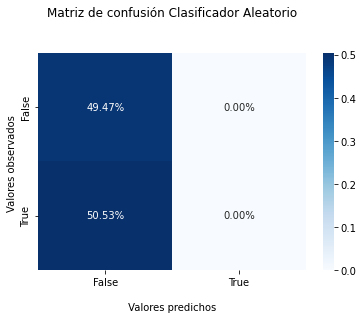

In [211]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Clasificador Aleatorio\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


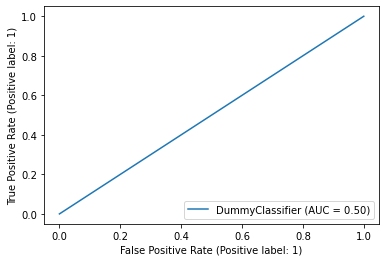

In [212]:
metrics.plot_roc_curve(dummy_clf, X_test, y_test) 

In [213]:
scores = cross_val_score(dummy_clf, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.50761421 0.50761421 0.50761421 0.50761421 0.51020408 0.51020408
 0.51020408 0.51020408 0.50510204 0.50510204]
Precisión de validación cruzada: 0.508 +/- 0.002


## k-nearest neighbors 


In [214]:
dummy_KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_knn = dummy_KNN.predict(X_test)

In [215]:
cf_matrix = confusion_matrix(y_test, y_pred_knn)

print(cf_matrix)

[[218 106]
 [104 227]]


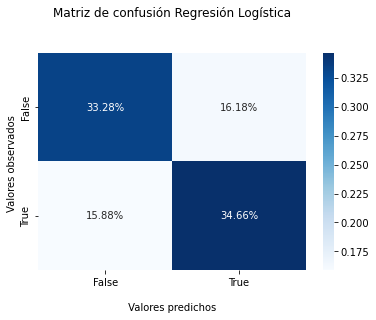

In [216]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Regresión Logística\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


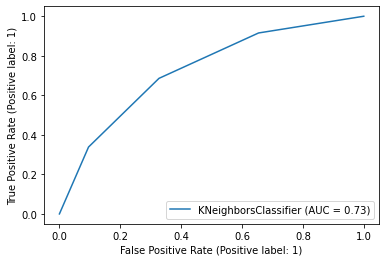

In [217]:
metrics.plot_roc_curve(dummy_KNN, X_test, y_test) 

In [218]:
scores = cross_val_score(dummy_KNN, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.68020305 0.62944162 0.70050761 0.69543147 0.67346939 0.69387755
 0.68877551 0.68877551 0.63265306 0.69387755]
Precisión de validación cruzada: 0.678 +/- 0.024


## Logistic Regression

In [219]:
reg_log = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_reg_log = reg_log.predict(X_test)

In [220]:
cf_matrix = confusion_matrix(y_test, y_pred_reg_log)

print(cf_matrix)

[[324   0]
 [331   0]]


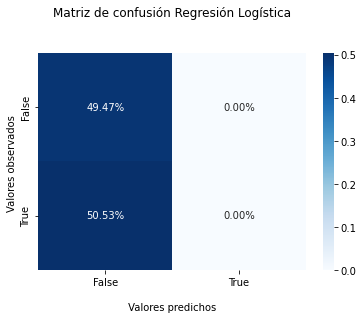

In [221]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Regresión Logística\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


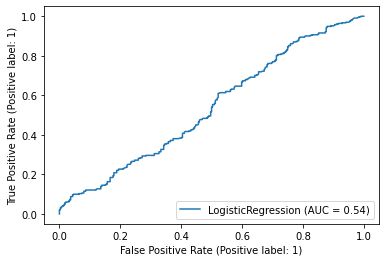

In [222]:
metrics.plot_roc_curve(reg_log, X_test, y_test) 

In [223]:
scores = cross_val_score(reg_log, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.50761421 0.50761421 0.50761421 0.50761421 0.51020408 0.51020408
 0.51020408 0.51020408 0.50510204 0.50510204]
Precisión de validación cruzada: 0.508 +/- 0.002


## Random Forest

In [224]:
rf =RandomForestClassifier(max_depth=2, random_state=0).fit( X_train, y_train )

# prediction
y_pred_rf = rf.predict( X_test)

In [225]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)

print(cf_matrix)

[[228  96]
 [ 95 236]]


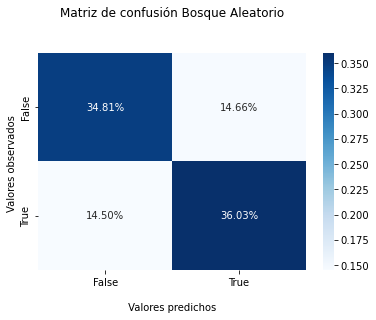

In [226]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Bosque Aleatorio\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


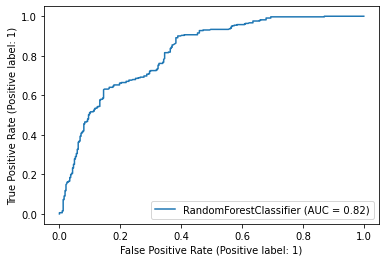

In [227]:
metrics.plot_roc_curve(rf, X_test, y_test) 

In [228]:
scores = cross_val_score(rf, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.74111675 0.72081218 0.69035533 0.73604061 0.71938776 0.71938776
 0.75       0.68877551 0.69897959 0.66836735]
Precisión de validación cruzada: 0.713 +/- 0.025


## Naive Bayes

In [229]:
nb =GaussianNB().fit( X_train, y_train )

# prediction
y_pred_NB = nb.predict( X_test)

In [230]:
cf_matrix = confusion_matrix(y_test, y_pred_NB)

print(cf_matrix)

[[192 132]
 [183 148]]


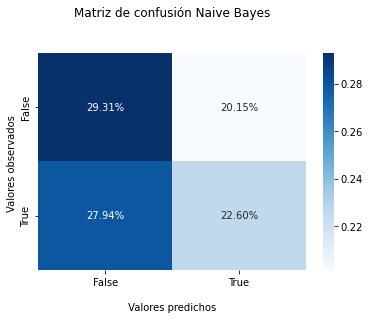

In [231]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Naive Bayes\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


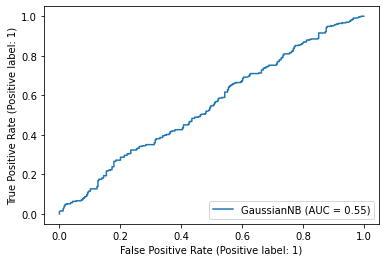

In [232]:
metrics.plot_roc_curve(nb, X_test, y_test) 

In [233]:
scores = cross_val_score(nb, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.54822335 0.47715736 0.50253807 0.54314721 0.47959184 0.4744898
 0.56122449 0.55102041 0.53571429 0.46938776]
Precisión de validación cruzada: 0.514 +/- 0.035


## XGBoost 

In [234]:
xgb_cl = xgb.XGBClassifier().fit( X_train, y_train )

y_pred_xgb = xgb_cl.predict(X_test)

[08:59:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [235]:
cf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(cf_matrix)

[[277  47]
 [ 39 292]]


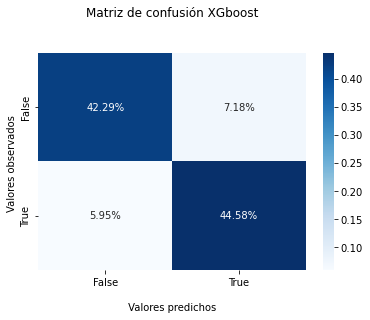

In [236]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión XGboost\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


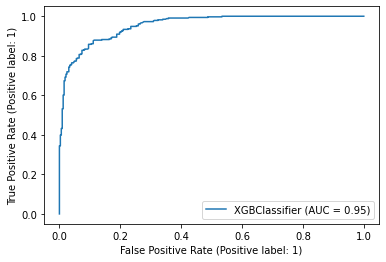

In [237]:
metrics.plot_roc_curve(xgb_cl, X_test, y_test) 

In [238]:
scores = cross_val_score(xgb_cl, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Puntajes obtenidos: [0.89340102 0.80203046 0.80203046 0.87817259 0.87244898 0.87244898
 0.85714286 0.83163265 0.83163265 0.84183673]
Precisión de validación cruzada: 0.848 +/- 0.030


## Summary of results

In [239]:
scores_bln = cross_val_score(dummy_clf, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_knn = cross_val_score(dummy_KNN, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_log = cross_val_score(reg_log, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_rf = cross_val_score(rf, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_nb = cross_val_score(nb, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_xgb = cross_val_score(xgb_cl, X=X_train, y=y_train, cv=10, n_jobs=1)


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [240]:
res_baseline = pd.DataFrame( {'Model Name': 'Baseline', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_bln),np.std(scores_bln))},index=[0] ) 
res_KNN = pd.DataFrame( {'Model Name': 'KNN', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_knn),np.std(scores_knn))},index=[0] ) 
res_lr = pd.DataFrame( {'Model Name': 'Logistic Regression',
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_log),np.std(scores_log))},index=[0] ) 
res_rf = pd.DataFrame( {'Model Name': 'Random Forest',
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_rf),np.std(scores_rf))},index=[0] ) 
res_nb = pd.DataFrame( {'Model Name': 'Naive Bayes', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_nb),np.std(scores_nb))},index=[0] ) 
res_xgb = pd.DataFrame( {'Model Name': 'XGBoost', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_xgb),np.std(scores_xgb))},index=[0] )
Accuracy = pd.concat([res_baseline,res_KNN,res_lr,res_rf,res_nb,res_xgb])

In [241]:
Accuracy.sort_values('Accuracy', ascending = False)

,Model Name,Accuracy
0,XGBoost,0.848 +/- 0.030
0,Random Forest,0.713 +/- 0.025
0,KNN,0.678 +/- 0.024
0,Naive Bayes,0.514 +/- 0.035
0,Baseline,0.508 +/- 0.002
0,Logistic Regression,0.508 +/- 0.002


Thus, the model XGboost is going to be selected for forecasting. But first, let see if a better version if achivable by means of an hyperparameter tuning process

## Model Hyperparameter Tuning

In [242]:
dtrain = xgb.DMatrix(X_test, label=y_test)

def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
                'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]


In [243]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'learning_rate':(0,1),
                                             'n_estimators':(100,120)})

In [244]:
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
[09:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_r

|  4        | -0.4115   |  0.03804  |  0.616    |  4.018    |  105.8    |
[09:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not

|  8        | -0.3699   |  0.272    |  0.5102   |  4.283    |  114.8    |
[09:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not

|  12       | -0.3592   |  0.9761   |  0.3299   |  4.381    |  101.2    |
[09:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not

In [245]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

{'gamma': 0.2940344944882958, 'learning_rate': 0.16764789888342757, 'max_depth': 9.80771676937412, 'n_estimators': 119.82045410739465}


In [246]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data

classifier2 = xgb.XGBClassifier(**params).fit(X_test, y_test)

[09:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [247]:
pickle.dump( classifier2, open( 'model/final_model.pkl', 'wb' ) )

In [248]:
y_pred_xgb_param = classifier2.predict(X_test)

In [249]:
cf_matrix = confusion_matrix(y_test, y_pred_xgb_param)

print(cf_matrix)

[[321   3]
 [  6 325]]


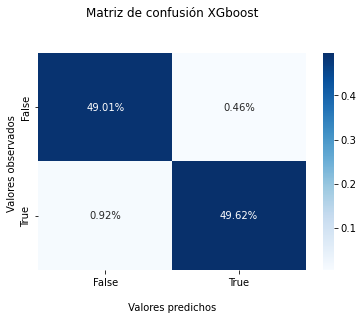

In [250]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión XGboost\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


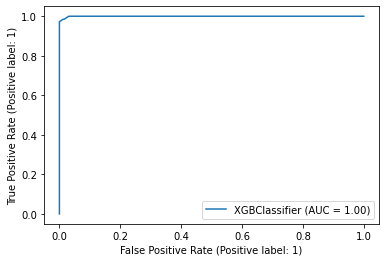

In [251]:
metrics.plot_roc_curve(classifier2, X_test, y_test) 

In [252]:
scores = cross_val_score(classifier2, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Puntajes obtenidos: [0.9035533  0.81725888 0.79187817 0.88324873 0.86734694 0.85714286
 0.8622449  0.83163265 0.85714286 0.85714286]
Precisión de validación cruzada: 0.853 +/- 0.030


## Using the model to predict new data

In [253]:
nueva = pd.read_csv('Base_nueva_DC.csv',encoding = "ISO-8859-1", sep =';',parse_dates=['fecha_ult_desembolso'], 
                  dtype = {
                      'Id_Cliente':str,
                      'Ciudad':str,
                      ' Patrimonio ':int,
                      ' Ingresos_Mensuales ':int,
                      'No_hijos':int,
                      'oficina':str,
                      'monto_credito':int,
                      'tasa':float,
                      'saldo_capital':int,
                      'Antiguedad_en_meses':int,
                      'Max_dias_mora':int,
                      'plazo_dias':int,
                      'Edad':int
                  })


In [254]:
nueva['mes_ult_desembolso'] = nueva['fecha_ult_desembolso'].dt.month
nueva = nueva.rename(columns = {' Ingresos_Mensuales ':'Ingresos_Mensuales',
                              ' Patrimonio ':'Patrimonio'})

In [255]:
nueva

,Id_Cliente,Ciudad,Patrimonio,Ingresos_Mensuales,No_hijos,oficina,fecha_ult_desembolso,monto_credito,tasa,saldo_capital,saldo_Ahorro,Antiguedad_en_meses,Max_dias_mora,plazo_dias,Edad,mes_ult_desembolso
0,427658,Cartagena,745968,1614094,0,4024,2017-12-30,1500000,33.93,1357387,33438,12,0,900,65,12
1,427659,Barranquilla,834415,920234,1,4011,2017-12-18,1500000,33.93,392262,0,12,0,540,40,12
2,427670,Barranquilla,1164858,1568317,1,7032,2018-02-17,1064170,0.30,211724,0,12,0,540,36,2
3,427671,Cali,1187587,796660,1,7032,2017-12-25,2338552,0.30,828993,0,12,0,720,47,12
4,427720,Cartagena,2840488,1474771,0,7025,2018-01-23,2385560,33.93,1997956,0,12,0,720,56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,428626,Cartagena,37964203,477534,1,4003,2017-11-29,9000000,33.93,7810084,18603,120,0,1080,30,11
1496,428844,Barranquilla,46168677,1516403,0,4003,2017-11-29,8900000,33.93,7810084,18603,120,0,1080,44,11
1497,428405,Bogotá,28739705,848160,1,4030,2017-12-15,9000000,33.93,9000000,19713,120,0,720,41,12
1498,428623,Cali,37858892,1041188,2,4030,2017-12-15,9000000,33.93,9000000,19713,120,0,720,48,12


In [256]:
X = nueva[[ 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'mes_ult_desembolso']]

In [257]:
ciudad = pd.get_dummies(nueva['Ciudad'], prefix='C')

In [258]:
X= X.join(ciudad)

In [259]:
X.head().T

,0,1,2,3,4
Patrimonio,745968.00,834415.00,1164858.0,1187587.0,2840488.00
Ingresos_Mensuales,1614094.00,920234.00,1568317.0,796660.0,1474771.00
No_hijos,0.00,1.00,1.0,1.0,0.00
monto_credito,1500000.00,1500000.00,1064170.0,2338552.0,2385560.00
tasa,33.93,33.93,0.3,0.3,33.93
saldo_capital,1357387.00,392262.00,211724.0,828993.0,1997956.00
saldo_Ahorro,33438.00,0.00,0.0,0.0,0.00
Antiguedad_en_meses,12.00,12.00,12.0,12.0,12.00
Max_dias_mora,0.00,0.00,0.0,0.0,0.00
plazo_dias,900.00,540.00,540.0,720.0,720.00


In [260]:
mms = joblib.load('parameter/Patrimonio.sav')
X['Patrimonio'] = mms.transform( X[['Patrimonio']].values )

In [261]:
mms = joblib.load('parameter/Ingresos_Mensuales.sav')
X['Ingresos_Mensuales'] = mms.transform( X[['Ingresos_Mensuales']].values )

In [262]:
mms = joblib.load('parameter/No_hijos.sav')
X['No_hijos'] = mms.transform( X[['No_hijos']].values )

In [263]:
mms = joblib.load('parameter/monto_credito.sav')
X['monto_credito'] = mms.transform( X[['monto_credito']].values )

In [264]:
mms = joblib.load('parameter/tasa.sav')
X['tasa'] = mms.transform( X[['tasa']].values )

In [265]:
mms = joblib.load('parameter/saldo_capital.sav')
X['saldo_capital'] = mms.transform( X[['saldo_capital']].values )

In [266]:
mms = joblib.load('parameter/saldo_Ahorro.sav')
X['saldo_Ahorro'] = mms.transform( X[['saldo_Ahorro']].values )

In [267]:
mms = joblib.load('parameter/Antiguedad_en_meses.sav')
X['Antiguedad_en_meses'] = mms.transform( X[['Antiguedad_en_meses']].values )

In [268]:
mms = joblib.load('parameter/Max_dias_mora.sav')
X['Max_dias_mora'] = mms.transform( X[['Max_dias_mora']].values )

In [269]:
mms = joblib.load('parameter/Edad.sav')
X['Edad'] = mms.transform( X[['Edad']].values )

In [270]:
mms = joblib.load('parameter/plazo_dias.sav')
X['plazo_dias'] = mms.transform( X[['plazo_dias']].values )

In [271]:
mms = joblib.load('parameter/mes_ult_desembolso.sav')
X['mes_ult_desembolso'] = mms.transform( X[['mes_ult_desembolso']].values )

# X['semana_ult_desembolso'] = mms.fit_transform( X[['semana_ult_desembolso']].values )

In [272]:
y_xgb = classifier2.predict(X)
y_xgb_proba = classifier2.predict_proba(X)
nueva = nueva.join(pd.DataFrame(y_xgb_proba))
# nueva = nueva.join(pd.DataFrame(y_xgb))

In [273]:
pd.DataFrame(y_xgb).rename(columns = {0:'Aceptará Campaña'}).value_counts('Aceptará Campaña')

Aceptará Campaña
0    971
1    529
dtype: int64

In [274]:
nueva = nueva.rename(columns={0:'Prob_no_aceptar',1:'Prob_aceptar'})

In [275]:
nueva.sort_values('Prob_aceptar', ascending = False)

,Id_Cliente,Ciudad,Patrimonio,Ingresos_Mensuales,No_hijos,oficina,fecha_ult_desembolso,monto_credito,tasa,saldo_capital,saldo_Ahorro,Antiguedad_en_meses,Max_dias_mora,plazo_dias,Edad,mes_ult_desembolso,Prob_no_aceptar,Prob_aceptar
1189,428598,Barranquilla,37110912,963261,0,4025,2017-12-26,3000000,33.93,2723065,33550,120,0,1080,59,12,0.003059,0.996941
1217,428294,Barranquilla,24800007,558645,0,4010,2017-02-12,3069840,33.93,3069840,40345,120,0,540,61,2,0.003559,0.996441
637,429041,Barranquilla,53539572,905681,0,7025,2018-09-01,2000000,33.93,1706385,33642,72,0,360,65,9,0.004739,0.995261
477,428988,Barranquilla,51636155,1047269,0,7039,2017-12-15,2200000,33.93,882169,13769,51,0,720,55,12,0.005079,0.994921
134,428820,Barranquilla,45332993,523887,0,7032,2018-06-02,5227592,0.30,4430053,21836,126,22,1080,61,6,0.005270,0.994730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,427977,Cali,13007139,2193031,1,7025,2017-11-15,500000,33.93,374110,4610,116,0,510,47,11,0.991137,0.008863
1465,428203,Cali,21732350,2060181,1,4011,2017-12-26,5000000,33.93,3672502,159843,120,22,1080,40,12,0.991159,0.008841
866,428220,Cali,22266568,1502855,1,7032,2017-11-29,4000000,0.30,2535040,49979,92,0,1080,22,11,0.991775,0.008225
1066,428170,Cali,20265693,1533982,1,4030,2017-11-13,2500000,33.93,2500000,51337,113,0,360,21,11,0.991920,0.008080
